# Import Libraries

In [1]:
# Importing required libraries for the EDA.
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# Data Gathering

In [2]:
# Source of the dataset
# Note: The dataset link and column names might need adjustment based on the actual dataset.
dataset_link = "https://raw.githubusercontent.com/SreenivasKasulanati/AI_Project/main/framingham.csv"
stroke_df = pd.read_csv(dataset_link)

# Display sample record elements of the dataframe
print(stroke_df.head())

   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2 

# Data Preprocessing

In [3]:
# Summary of the dataset
# Note: The column name adjustments may be needed based on the actual dataset.
stroke_df.rename(columns={"TenYearCHD": "stroke", "male": "gender"}, inplace=True)
stroke_df['gender'] = stroke_df['gender'].map({0: 'F', 1: 'M'})

# Convert numeric variables to factor variables
categorical_columns = ['gender', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'stroke']
for column in categorical_columns:
    stroke_df[column] = stroke_df[column].astype('category')

# Convert BMI to numeric
stroke_df['BMI'] = pd.to_numeric(stroke_df['BMI'], errors='coerce')

# Display summary statistics of the dataset
print(stroke_df.describe(include='all'))

       gender          age    education  currentSmoker   cigsPerDay  BPMeds  \
count    4238  4238.000000  4133.000000         4238.0  4209.000000  4185.0   
unique      2          NaN          NaN            2.0          NaN     2.0   
top         F          NaN          NaN            0.0          NaN     0.0   
freq     2419          NaN          NaN         2144.0          NaN  4061.0   
mean      NaN    49.584946     1.978950            NaN     9.003089     NaN   
std       NaN     8.572160     1.019791            NaN    11.920094     NaN   
min       NaN    32.000000     1.000000            NaN     0.000000     NaN   
25%       NaN    42.000000     1.000000            NaN     0.000000     NaN   
50%       NaN    49.000000     2.000000            NaN     0.000000     NaN   
75%       NaN    56.000000     3.000000            NaN    20.000000     NaN   
max       NaN    70.000000     4.000000            NaN    70.000000     NaN   

        prevalentStroke  prevalentHyp  diabetes    

## Data Cleaning - Bread First Search Imputation

In [6]:
from collections import deque

def bfs_imputation_single_column(df, column):
    queue = deque([column.name])  # Initialize the queue with the column name
    visited = set()

    while queue:
        current_feature = queue.popleft()
        if current_feature not in visited:
            # Impute missing values in the current feature
            column.fillna(column.mean(), inplace=True)

            # Mark the feature as visited
            visited.add(current_feature)

            # Add dependent features to the queue
            dependent_features = [dep_col for dep_col in df.columns if df[dep_col].isnull().any()]
            for dependent_feature in dependent_features:
                if dependent_feature not in visited and dependent_feature not in queue:
                    queue.append(dependent_feature)


# Apply BFS imputation for the target column
bfs_imputation_single_column(stroke_df,stroke_df['cigsPerDay'])
bfs_imputation_single_column(stroke_df,stroke_df['heartRate'])
bfs_imputation_single_column(stroke_df,stroke_df['BMI'])
bfs_imputation_single_column(stroke_df,stroke_df['glucose'])
bfs_imputation_single_column(stroke_df,stroke_df['totChol'])

In [7]:
# Data Cleaning - Checking for null values
print("The NA's in the dataset is:", stroke_df.isna().sum().sum())

# Replacing Education NA values with mean value
stroke_df['education'].fillna(stroke_df['education'].mean(), inplace=True)
stroke_df['education'] = stroke_df['education'].astype(int)

# Replacing BPMeds NA values with mean value
stroke_df['BPMeds'].fillna(0, inplace=True)

print("The NA's in the dataset after replacing null values is:", stroke_df.isna().sum().sum())

# Summary after data-cleaning
print(stroke_df.describe(include='all'))

The NA's in the dataset is: 158
The NA's in the dataset after replacing null values is: 0
       gender          age    education  currentSmoker   cigsPerDay  BPMeds  \
count    4238  4238.000000  4238.000000         4238.0  4238.000000  4238.0   
unique      2          NaN          NaN            2.0          NaN     2.0   
top         F          NaN          NaN            0.0          NaN     0.0   
freq     2419          NaN          NaN         2144.0          NaN  4114.0   
mean      NaN    49.584946     1.954696            NaN     9.003089     NaN   
std       NaN     8.572160     1.018510            NaN    11.879230     NaN   
min       NaN    32.000000     1.000000            NaN     0.000000     NaN   
25%       NaN    42.000000     1.000000            NaN     0.000000     NaN   
50%       NaN    49.000000     2.000000            NaN     0.000000     NaN   
75%       NaN    56.000000     3.000000            NaN    20.000000     NaN   
max       NaN    70.000000     4.000000  

## Feature Engineering

In [8]:
# Subsetting the data for various analyses
stroke_1 = stroke_df[stroke_df['stroke'] == 1]
stroke_0 = stroke_df[stroke_df['stroke'] == 0]
stroke_1_female = stroke_df[(stroke_df['stroke'] == 1) & (stroke_df['gender'] == "F")]
stroke_1_male = stroke_df[(stroke_df['stroke'] == 1) & (stroke_df['gender'] == "M")]

# Creating different columns for BMI, age, and average_glucose_level based on different bucketing for each variable
stroke_df['BMI.cat'] = pd.cut(stroke_df['BMI'], bins=[-np.inf, 18.5, 25, 30, 40, np.inf],
                              labels=['underweight', 'normal', 'overweight', 'obesity', 'severe obesity'])
stroke_df['gluc.cat'] = pd.cut(stroke_df['glucose'], bins=[-np.inf, 60, 90, 120, 180, 273, np.inf],
                               labels=['Below 60', '60 - 90', '90 - 120', '120 - 180', '180 - 273', 'Beyond 273'])
stroke_df['age.cat'] = pd.cut(stroke_df['age'], bins=[-np.inf, 20, 40, 60, 80, np.inf],
                              labels=['Under 20', '20-40', '40-60', '60-80', 'above 80'])

# Subsetting data for stroke == 1
stroke_1 = stroke_df[stroke_df['stroke'] == 1]

#print(stroke_1)

# Data Visualization

## Univariate Analysis

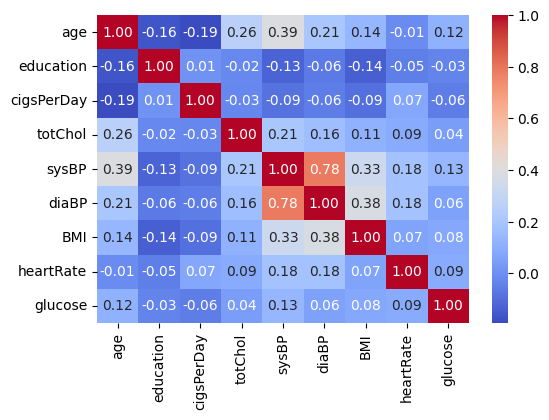

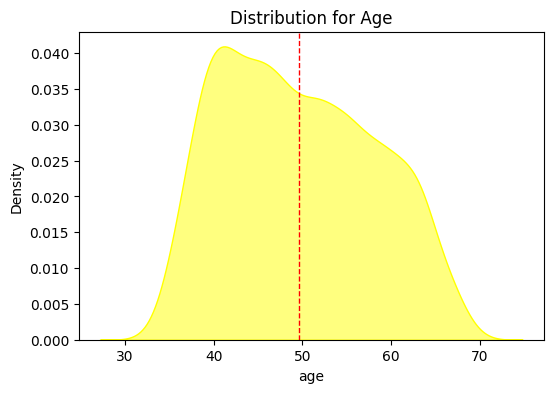

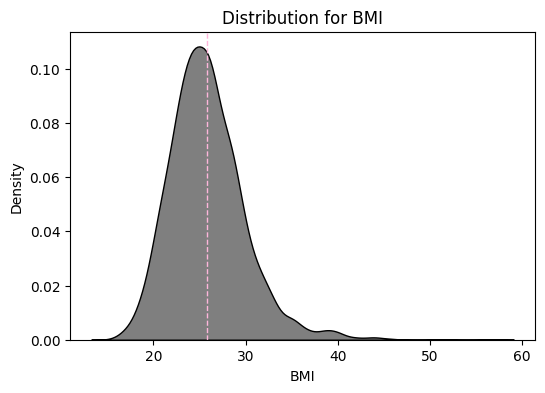

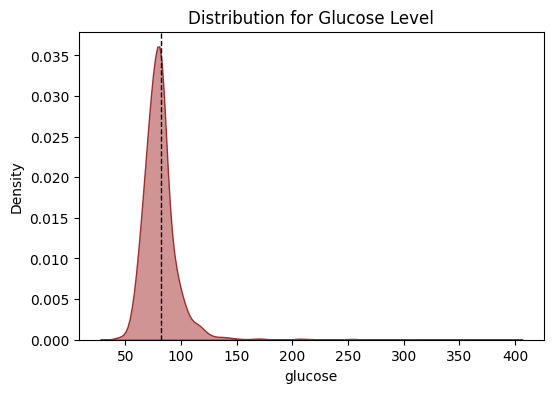

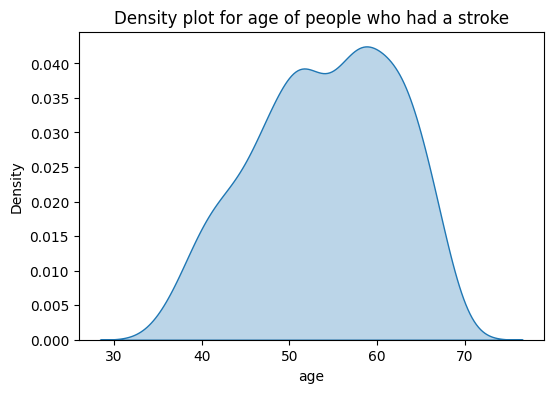

In [9]:
# Correlation matrix
numeric_df = stroke_df.select_dtypes(include=[np.number])

# Correlation matrix
corr_mat = numeric_df.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

# Univariate analysis
# Density plot for Age
plt.figure(figsize=(6, 4))
sns.kdeplot(stroke_df['age'], fill=True, color='yellow', alpha=0.5)
plt.axvline(stroke_df['age'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.title('Distribution for Age')
plt.show()

# Density plot for BMI
plt.figure(figsize=(6, 4))
sns.kdeplot(stroke_df['BMI'], fill=True, color='black', alpha=0.5)
plt.axvline(stroke_df['BMI'].mean(), color='#FEB6DB', linestyle='dashed', linewidth=1)
plt.title('Distribution for BMI')
plt.show()

# Density plot for Glucose
plt.figure(figsize=(6, 4))
sns.kdeplot(stroke_df['glucose'], fill=True, color='brown', alpha=0.5)
plt.axvline(stroke_df['glucose'].mean(), color='black', linestyle='dashed', linewidth=1)
plt.title('Distribution for Glucose Level')
plt.show()

# Density plot for Age
plt.figure(figsize=(6, 4))
sns.kdeplot(stroke_1['age'], fill=True, alpha=0.3)
plt.title('Density plot for age of people who had a stroke')
plt.show()



## Bivariate Analysis

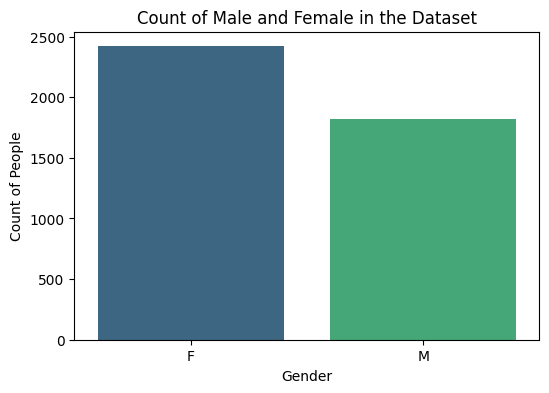

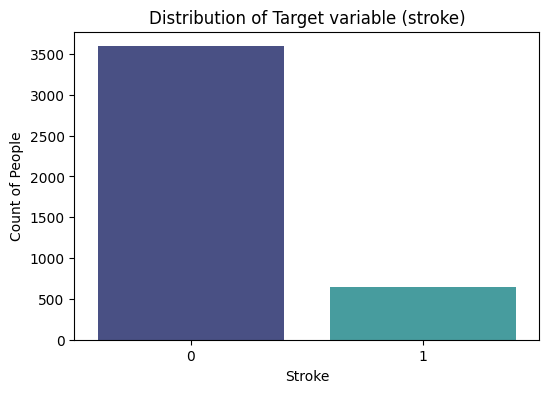

In [10]:
# Bar plot for Gender
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=stroke_df, palette='viridis')
plt.title('Count of Male and Female in the Dataset')
plt.xlabel('Gender')
plt.ylabel('Count of People')
plt.show()

# Distribution of the target variable (stroke)
plt.figure(figsize=(6, 4))
sns.countplot(x='stroke', data=stroke_df, palette='mako')
plt.title('Distribution of Target variable (stroke)')
plt.xlabel('Stroke')
plt.ylabel('Count of People')
plt.show()

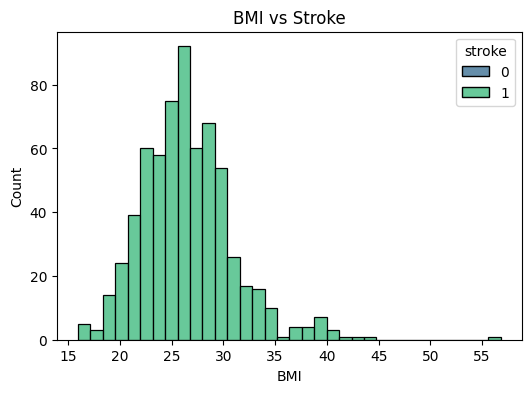

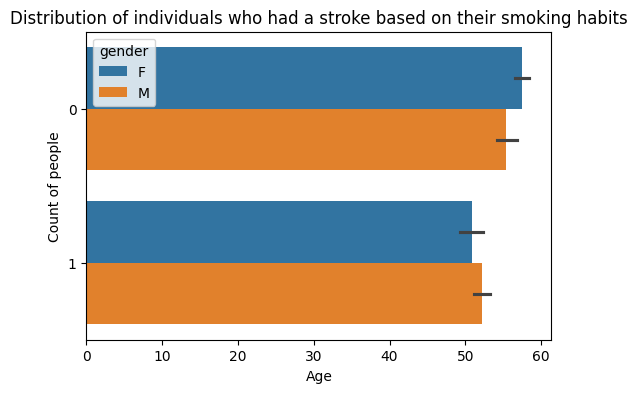

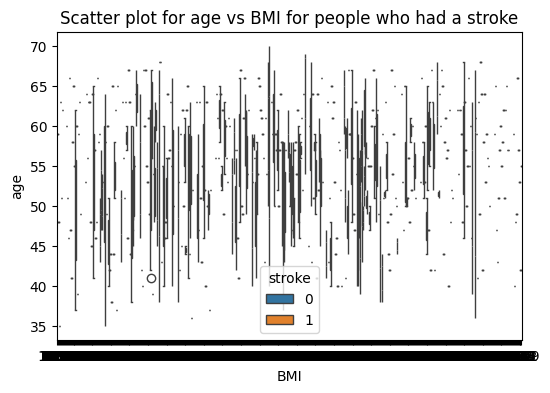

In [11]:
# BMI vs Stroke
plt.figure(figsize=(6, 4))
sns.histplot(stroke_1, x='BMI', fill=True, hue='stroke', multiple='stack', palette='viridis')
plt.title('BMI vs Stroke')
plt.show()

# Gender vs Smoking and Age
plt.figure(figsize=(6, 4))
sns.barplot(x='age', y='currentSmoker', hue='gender', data=stroke_1, dodge=True)
plt.title('Distribution of individuals who had a stroke based on their smoking habits')
plt.xlabel('Age')
plt.ylabel('Count of people')
plt.show()

# Age vs BMI Scatter Plot
plt.figure(figsize=(6, 4))
sns.boxplot(x='BMI', y='age', hue='stroke', data=stroke_1)
plt.title('Scatter plot for age vs BMI for people who had a stroke')
plt.show()

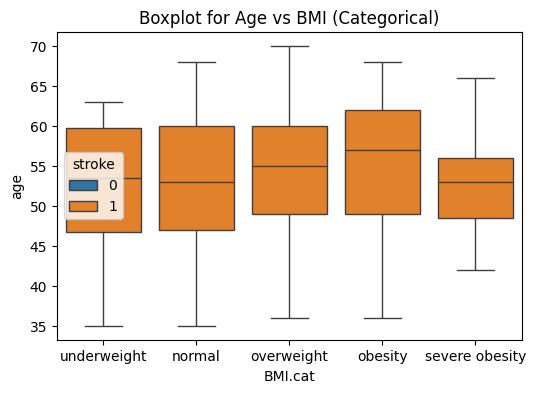

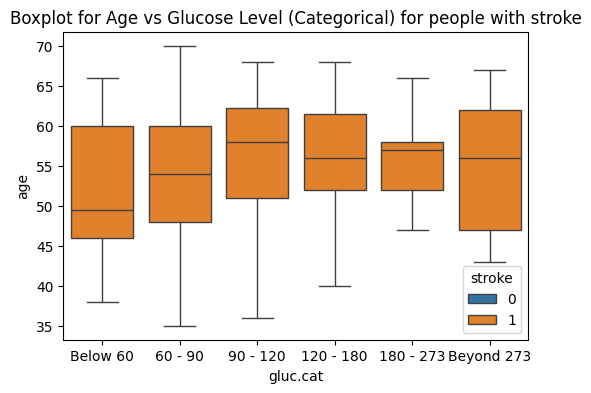

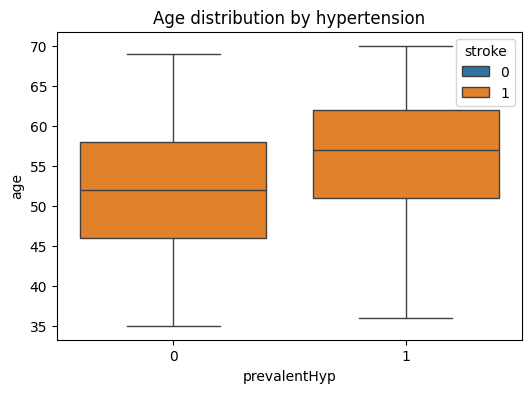

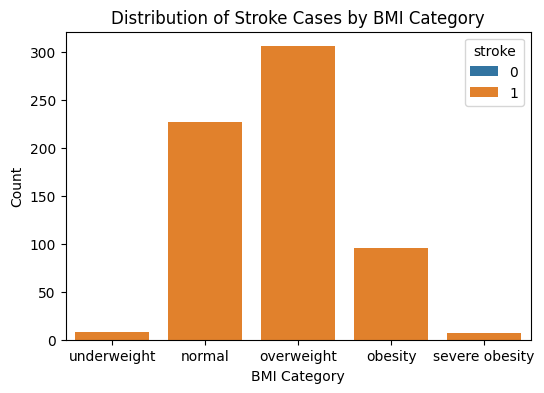

In [12]:
# BMI Categories vs Age
plt.figure(figsize=(6, 4))
sns.boxplot(x='BMI.cat', y='age', hue='stroke', data=stroke_1)
plt.title('Boxplot for Age vs BMI (Categorical)')
plt.show()

# Age vs Glucose Level (Categorical) for people with stroke
plt.figure(figsize=(6, 4))
sns.boxplot(x='gluc.cat', y='age', hue='stroke', data=stroke_1)
plt.title('Boxplot for Age vs Glucose Level (Categorical) for people with stroke')
plt.show()

# Age distribution by hypertension
plt.figure(figsize=(6, 4))
sns.boxplot(x='prevalentHyp', y='age', hue='stroke', data=stroke_1)
plt.title('Age distribution by hypertension')
plt.show()

# BMI Category vs Stroke Count
plt.figure(figsize=(6, 4))
sns.countplot(x='BMI.cat', hue='stroke', data=stroke_1)
plt.title('Distribution of Stroke Cases by BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.show()

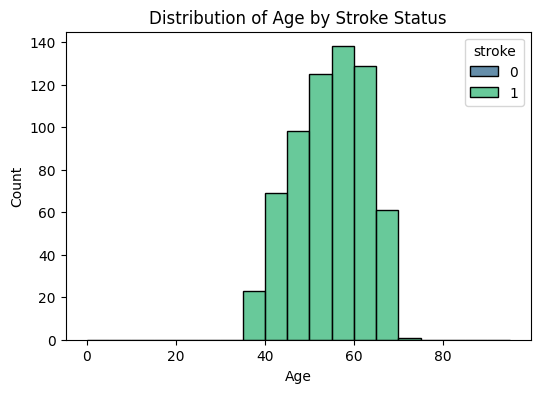

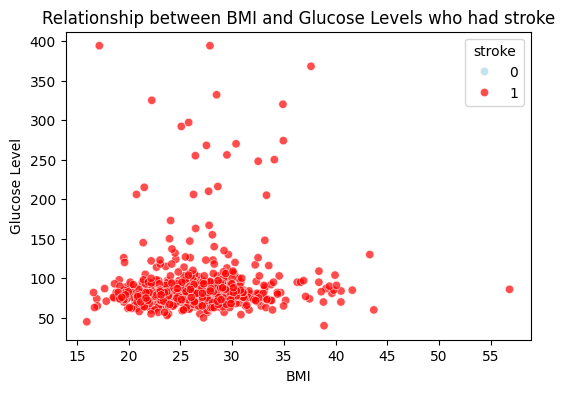

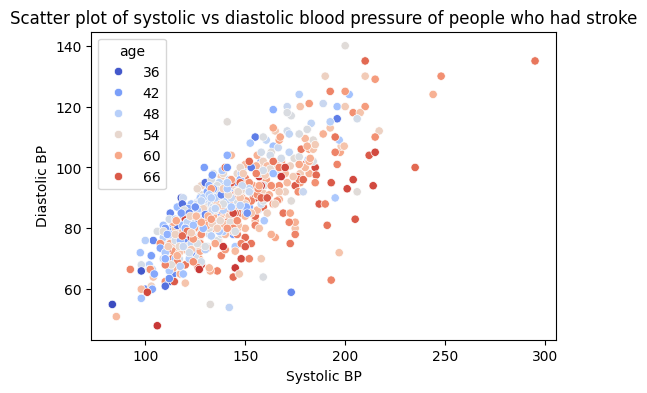

In [13]:
# Distribution of Age by Stroke Status
plt.figure(figsize=(6, 4))
sns.histplot(stroke_1, x='age', fill=True, hue='stroke', multiple='stack', bins=range(0, 100, 5), palette='viridis')
plt.title('Distribution of Age by Stroke Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# BMI vs Glucose Levels for people who had stroke
plt.figure(figsize=(6, 4))
sns.scatterplot(x='BMI', y='glucose', hue='stroke', data=stroke_1, alpha=0.7, palette=['lightblue', 'red'])
plt.title('Relationship between BMI and Glucose Levels who had stroke')
plt.xlabel('BMI')
plt.ylabel('Glucose Level')
plt.show()

# Scatter plot of systolic vs diastolic blood pressure of people who had stroke
plt.figure(figsize=(6, 4))
sns.scatterplot(x='sysBP', y='diaBP', hue='age', data=stroke_1, palette='coolwarm')
plt.title('Scatter plot of systolic vs diastolic blood pressure of people who had stroke')
plt.xlabel('Systolic BP')
plt.ylabel('Diastolic BP')
plt.show()

# Hypothesis Testing

In [14]:
#Null Hypothesis (H0): There is no significant association between the features and the target variable 'stroke.'

#Alternate Hypothesis (H1): There is a significant association between the features and the target variable 'stroke.'

def chi_square_test(data, x, y):
    crosstab = pd.crosstab(data[x], data[y])
    chi2, p, _, _ = stats.chi2_contingency(crosstab)
    return chi2, p

# T-test for numerical variables
def t_test(data, x, y):
    group1 = data[data[y] == 0][x]
    group2 = data[data[y] == 1][x]
    t_stat, p = stats.ttest_ind(group1, group2)
    return t_stat, p

# Variables
categorical_vars = ['gender', 'currentSmoker', 'prevalentStroke', 'prevalentHyp', 'diabetes']
numerical_vars = ['totChol', 'sysBP', 'diaBP', 'BMI', 'age', 'glucose']

# Results storage
chi_square_results = {}
t_test_results = {}

# Chi-square tests
for var in categorical_vars:
    chi2_stat, p_value = chi_square_test(stroke_df, var, 'stroke')
    chi_square_results[var] = {'chi2_stat': chi2_stat, 'p_value': p_value}

print(chi_square_results)
# T-tests
for var in numerical_vars:
    t_stat, p_value = t_test(stroke_df, var, 'stroke')
    t_test_results[var] = {'t_stat': t_stat, 'p_value': p_value}

print(t_test_results)

{'gender': {'chi2_stat': 32.64296047074444, 'p_value': 1.1073976912877559e-08}, 'currentSmoker': {'chi2_stat': 1.497705652757576, 'p_value': 0.2210247224594497}, 'prevalentStroke': {'chi2_stat': 14.020762729079046, 'p_value': 0.00018080313034275284}, 'prevalentHyp': {'chi2_stat': 132.61099703660688, 'p_value': 1.0998229381834025e-30}, 'diabetes': {'chi2_stat': 38.44172261466515, 'p_value': 5.641334407100521e-10}}
{'totChol': {'t_stat': -5.330254736736741, 'p_value': 1.0317829452966822e-07}, 'sysBP': {'t_stat': -14.428160053171226, 'p_value': 4.19533989148915e-46}, 'diaBP': {'t_stat': -9.558161664540934, 'p_value': 1.9688347291884158e-21}, 'BMI': {'t_stat': -4.874124055142946, 'p_value': 1.1329148185890267e-06}, 'age': {'t_stat': -15.047419364230018, 'p_value': 6.845008587441734e-50}, 'glucose': {'t_stat': -7.894028381503949, 'p_value': 3.69800918353991e-15}}


Based on the analysis and the obtained p-values from both the chi-square and t-tests, which are lower than the chosen significance level of 0.05, there is substantial evidence to reject the null hypothesis. Therefore, we accept the alternate hypothesis for each test. This compelling statistical evidence supports the presence of significant associations between the examined categorical variables and the occurrence of stroke, as well as significant differences in means for the numerical variables between individuals with and without stroke.

Distribution of the target variable in train data before oversampling:
stroke
0    2531
1     435
Name: count, dtype: int64
Distribution of the target variable in train data after oversampling:
stroke
0    2531
1     575
Name: count, dtype: int64


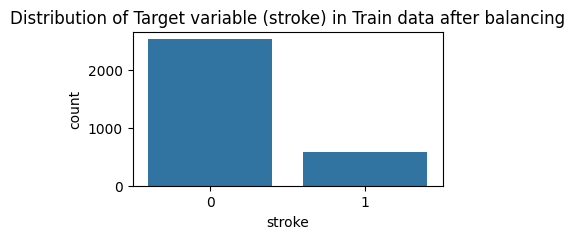

In [15]:
seed = 123
train_data, test_data = train_test_split(stroke_df, test_size=0.3, random_state=seed)

# Count the number of observations in each class before oversampling
print("Distribution of the target variable in train data before oversampling:")
print(train_data['stroke'].value_counts())

# Perform random oversampling by duplicating minority class samples
minority_class = train_data[train_data['stroke'] == 1]
oversampled_data = pd.concat([train_data, minority_class.sample(n=140, replace=True, random_state=seed)])

# Separate features (X_resampled) and target variable (y_resampled)
X_resampled = oversampled_data.drop('stroke', axis=1)
y_resampled = oversampled_data['stroke']

# Count the number of observations in each class after oversampling
print("Distribution of the target variable in train data after oversampling:")
print(y_resampled.value_counts())

# Visualization of the target variable after balancing
plt.figure(figsize=(4, 2))
sns.countplot(x=y_resampled)
plt.title('Distribution of Target variable (stroke) in Train data after balancing')
plt.show()


# Modeling

In [16]:
# Assuming cat_features is a list of column names containing categorical features
cat_features = ['gender', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'BMI.cat', 'gluc.cat',
       'age.cat']

label_encoder = LabelEncoder()

# Apply label encoding to both training and test data
for feature in cat_features:
    X_resampled[feature] = label_encoder.fit_transform(X_resampled[feature])
    test_data[feature] = label_encoder.fit_transform(test_data[feature])

# Create a Logistic Regression classifier
clf_LR = LogisticRegression(random_state=555)

# Cross-validation on the training set
scores = cross_val_score(clf_LR, X_resampled, y_resampled, cv=5, scoring="accuracy")
print("Train CV Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))

# Train the Logistic Regression classifier on the entire training set
clf_LR.fit(X_resampled, y_resampled)

# Evaluate on the test set
predicted_labels = clf_LR.predict(test_data.drop('stroke', axis=1))
true_labels = test_data['stroke']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Test Accuracy: %0.4f" % accuracy)

Train CV Accuracy: 0.814 (+/- 0.006)
Test Accuracy: 0.8325


## Decision Tree

In [17]:
# Decision Tree model with balanced data
tree_model_bal = DecisionTreeClassifier(random_state=123)
tree_model_bal.fit(X_resampled, y_resampled)

# Make predictions on the test data
test_preds = tree_model_bal.predict(test_data.drop('stroke', axis=1))

# The rest of your code for confusion matrix and performance metrics remains the same
# Confusion Matrix
dt_confusion_mat = confusion_matrix(test_data['stroke'], test_preds)
print("Confusion matrix from the decision tree: ")
print(dt_confusion_mat)

# Model Performance Metrics
accuracy = accuracy_score(test_data['stroke'], test_preds)
precision = precision_score(test_data['stroke'], test_preds)
recall = recall_score(test_data['stroke'], test_preds)
f1 = f1_score(test_data['stroke'], test_preds)

# Print performance metrics
print(f"Accuracy: {round(accuracy, 4) * 100}%")
print(f"Precision: {round(precision, 4) * 100}%")
print(f"Recall (Sensitivity): {round(recall, 4) * 100}%")
print(f"F1 Score: {round(f1, 4) * 100}%")


Confusion matrix from the decision tree: 
[[938 125]
 [163  46]]
Accuracy: 77.36%
Precision: 26.900000000000002%
Recall (Sensitivity): 22.009999999999998%
F1 Score: 24.21%


## Random Forest - Grid Search

In [13]:
# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=555)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Train the Random Forest with the best hyperparameters
best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_resampled, y_resampled)

# Testing Accuracy
test_preds = best_rf_classifier.predict(test_data.drop('stroke', axis=1))
true_labels = test_data['stroke']
test_accuracy = accuracy_score(true_labels, test_preds)
print("Testing Accuracy with Best Hyperparameters: %0.4f" % test_accuracy)

Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Testing Accuracy with Best Hyperparameters: 0.8412


## Random Forset with Best Hyperparameters

In [18]:
# Create a Random Forest classifier
clf_RF = RandomForestClassifier(n_estimators=100, random_state=555, max_depth= 20, min_samples_split= 2)

# Cross-validation on the training set
scores = cross_val_score(clf_RF, X_resampled, y_resampled, cv=5, scoring="accuracy")
print("Train CV Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))

# Train the Random Forest classifier on the entire training set
clf_RF.fit(X_resampled, y_resampled)

# Evaluate on the test set
predicted_labels = clf_RF.predict(test_data.drop('stroke', axis=1))
true_labels = test_data['stroke']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Test Accuracy: %0.4f" % accuracy)

Train CV Accuracy: 0.895 (+/- 0.049)
Test Accuracy: 0.8412


## XGBoost Classifier

In [20]:
clf_XGB = XGBClassifier(n_estimators = 100, seed=555,eval_metric='logloss')

clfs = []
scores = sklearn.model_selection.cross_val_score(clf_XGB, X_resampled, y_resampled, cv=5, scoring="accuracy")
print("Train CV Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
md = clf_XGB.fit(X_resampled, y_resampled)
clfs.append(md)
# print("Test Accuracy: %0.4f " % (sklearn.metrics.accuracy_score(clf_XGB.predict(test_data['stroke'], test_data.drop('stroke', axis=1)))))

# Assuming clf_XGB is your XGBoost classifier
predicted_labels = clf_XGB.predict(test_data.drop('stroke', axis=1))
true_labels = test_data['stroke']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Test Accuracy: %0.4f" % accuracy)

Train CV Accuracy: 0.869 (+/- 0.044)
Test Accuracy: 0.8302


## Hybrid - Voting Classifier

In [21]:
# Create individual classifiers
tree_classifier = DecisionTreeClassifier(random_state=123)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=555, max_depth= 20, min_samples_split= 2)
xgb_classifier = XGBClassifier(n_estimators=100, seed=555, eval_metric='logloss')

# Create a voting classifier
voting_classifier = VotingClassifier(
    estimators=[
        ('decision_tree', tree_classifier),
        ('random_forest', rf_classifier),
        ('xgboost', xgb_classifier)
    ],
    voting='hard'  # Use 'soft' if classifiers provide probabilities
)

# Cross-validation on the training set
scores = cross_val_score(voting_classifier, X_resampled, y_resampled, cv=5, scoring="accuracy")
print("Train CV Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))

# Train the ensemble on the entire training set
voting_classifier.fit(X_resampled, y_resampled)

# Evaluate on the test set
predicted_labels = voting_classifier.predict(test_data.drop('stroke', axis=1))
true_labels = test_data['stroke']

accuracy = accuracy_score(true_labels, predicted_labels)
print("Test Accuracy: %0.4f" % accuracy)

Train CV Accuracy: 0.884 (+/- 0.046)
Test Accuracy: 0.8357


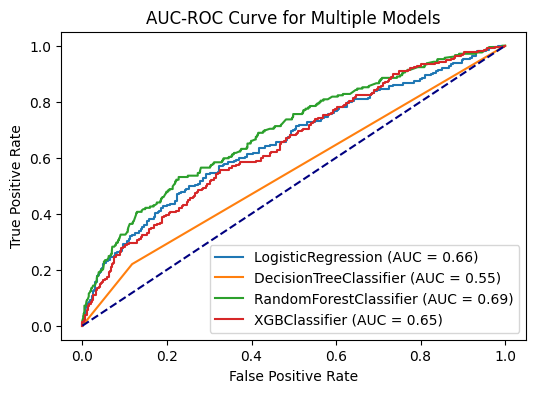

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

models = [clf_LR, tree_model_bal, clf_RF, clf_XGB]

# Plot AUC-ROC curves for each model
plt.figure(figsize=(6, 4))

for model in models:
    # Train the model
    model.fit(X_resampled, y_resampled)

    # Get probability scores for the positive class on the test set
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(test_data.drop('stroke', axis=1))[:, 1]  # Probability of positive class
    else:
        y_score = model.decision_function(test_data.drop('stroke', axis=1))

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(label_binarize(test_data['stroke'], classes=[0, 1]), y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')

# Plot the random line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve for Multiple Models')
plt.legend(loc='lower right')
plt.show()


# Conclusion

After an exhaustive exploration involving various models and diverse hyperparameter configurations, we have opted to proceed with the Random Forest algorithm. Specifically, we found that setting the hyperparameters to (n_estimators=100, random_state=555, max_depth=20, min_samples_split=2) yielded superior performance compared to other models with an accuracy value close to 85% (84.12)

In [94]:
test_data['BMI.cat']

1522    1
3428    2
245     1
1049    0
2287    0
       ..
141     0
3217    0
1804    2
1233    2
208     2
Name: BMI.cat, Length: 1272, dtype: int32

In [ ]:
from flask import Flask, render_template, request, jsonify

app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.form.to_dict()

        # Mapping for gender
        gender_mapping = {'M': 1, 'F': 0}
        data['gender'] = gender_mapping.get(data['gender'], data['gender'])

            # Mapping for currentSmoker
        current_smoker_mapping = {'No': 0, 'Yes': 1}
        data['currentSmoker'] = current_smoker_mapping.get(data['currentSmoker'], data['currentSmoker'])
    
        # Mapping for BPMeds
        bp_meds_mapping = {'No': 0, 'Yes': 1}
        data['BPMeds'] = bp_meds_mapping.get(data['BPMeds'], data['BPMeds'])
        
        # Mapping for prevalentStroke
        prevalent_stroke_mapping = {'No': 0, 'Yes': 1}
        data['prevalentStroke'] = prevalent_stroke_mapping.get(data['prevalentStroke'], data['prevalentStroke'])
        
        # Mapping for prevalentHyp
        prevalent_hyp_mapping = {'No': 0, 'Yes': 1}
        data['prevalentHyp'] = prevalent_hyp_mapping.get(data['prevalentHyp'], data['prevalentHyp'])
        
        # Mapping for diabetes
        diabetes_mapping = {'No': 0, 'Yes': 1}
        data['diabetes'] = diabetes_mapping.get(data['diabetes'], data['diabetes'])
    
        # Mapping for education
        education_mapping = {
            'Foundational Education': 0,
            'Intermediate Education': 1,
            'Advanced Education': 2,
            'Specialized Education': 3
        }
        data['education'] = education_mapping.get(data['education'], data['education'])
        
        # Add similar mappings for other fields
        
        # Mapping for BMIcat
        bmi_cat_mapping = {
            'underweight': 0,
            'normal': 1,
            'overweight': 2,
            'obesity': 3,
            'severeObesity': 4
        }
        data['BMI.cat'] = bmi_cat_mapping.get(data['BMIcat'], data['BMIcat'])
        
        # Mapping for glucCat
        gluc_cat_mapping = {
            'below60': 0,
            '60-90': 1,
            '90-120': 2,
            '120-180': 3,
            '180-273': 4,
            'beyond273': 5
        }
        data['gluc.cat'] = gluc_cat_mapping.get(data['glucCat'], data['glucCat'])
        
        # Mapping for ageCat
        age_cat_mapping = {
            'under20': 0,
            '20-40': 1,
            '40-60': 2,
            '60-80': 3,
            'above80': 4
        }
        data['age.cat'] = age_cat_mapping.get(data['ageCat'], data['ageCat'])

        print("Data received:", data)

        new_data = pd.DataFrame(data, index=[0])

        new_data = new_data.drop(columns=['BMIcat','glucCat','ageCat'])
        print(new_data)
        # new_data = list(data.values())
        # print(new_data)
        prediction = clf_RF.predict(new_data)

        probabilities = clf_RF.predict_proba(new_data)
        
        prediction_percentage = probabilities[0, 1]
        formatted_percentage = f"{prediction_percentage * 100:.2f}%"
         # Replace with your actual prediction logic
        print("The chance of having a heart stroke in next 10 years is:", prediction_percentage)
        return render_template('result.html', prediction_result=formatted_percentage)
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return jsonify({'error': 'An error occurred during prediction'})

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [01/Dec/2023 20:18:06] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2023 20:18:07] "GET /static/styles.css HTTP/1.1" 304 -
127.0.0.1 - - [01/Dec/2023 20:18:07] "GET /static/images/bg.jpg HTTP/1.1" 304 -


In [97]:
test_data

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,stroke,BMI.cat,gluc.cat,age.cat
1522,1,18,3,1,11,0,0,1,0,123,81,66,647,37,31,0,1,2,1
3428,1,6,0,1,23,0,0,1,0,68,103,67,552,26,45,0,2,3,0
245,1,13,0,1,21,0,0,1,0,107,106,52,656,50,25,0,1,2,1
1049,1,9,3,1,18,0,0,0,0,124,37,36,324,24,36,0,0,2,1
2287,0,21,2,0,0,0,0,0,0,145,87,50,335,11,45,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,1,10,0,1,23,0,0,0,0,94,15,27,293,21,15,0,0,2,1
3217,0,7,1,0,0,0,0,0,0,49,65,52,197,24,47,0,0,3,0
1804,0,16,1,0,0,0,0,0,0,129,121,60,338,25,36,0,2,2,1
1233,1,26,0,0,0,0,0,0,0,82,16,14,350,0,31,0,2,2,1


In [39]:
set(test_data['education'])

{0, 1, 2, 3}

In [86]:

new_data_list = test_data.drop('stroke', axis=1).iloc[73]
new_data_df = pd.DataFrame([new_data_list])

print(new_data_df.columns)
# Make a prediction
prediction = clf_RF.predict(new_data_df)

# If you need probability scores or confidence values
probabilities = clf_RF.predict_proba(new_data_df)

probabilities[0,1]

Index(['gender', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'BMI.cat', 'gluc.cat',
       'age.cat'],
      dtype='object')


0.54

In [106]:
Gender - 'gender' - M or F dropdown
Age -'age' - 0 to 120 Text field
education level - 'education' - 1 to 4 dropdown
Smoker? - 'currentSmoker' - No or Yes dropdown
Number of cigarettes consumed per day - 'cigsPerDay' - 0 to 100 Text field
Currently under Medication for BP? - 'BPMeds', No or Yes dropdown
History of heart stroke ?'prevalentStroke' - No or Yes dropdown
history of hypertension? 'prevalentHyp' - No or Yes dropdown
history of diabetes - 'diabetes' - No or Yes dropdown
cholestrol level - 'totChol' - 0 to 1000 text field 
systolic blood pressure level - 'sysBP' - 0 to 500 text field
diastolic blood pressure level - 'diaBP' - 0 to 300 text field
body mass index value - 'BMI' - 0 to 300 text field
heart rate value - 'heartRate'- 0 to 200 text field 
glucose level - 'glucose' -  0 to 500 text field
BMI Category - 'BMI.cat' - 'underweight', 'normal', 'overweight', 'obesity', 'severe obesity', drop down
Glucose Category - 'gluc.cat' - 'Below 60', '60 - 90', '90 - 120', '120 - 180', '180 - 273', 'Beyond 273',  drop down
Age Category - 'age.cat' - 'Under 20', '20-40', '40-60', '60-80', 'above 80', drop down


stroke_df['gluc.cat'] = pd.cut(stroke_df['glucose'], bins=[-np.inf, 60, 90, 120, 180, 273, np.inf],
                               labels=['Below 60', '60 - 90', '90 - 120', '120 - 180', '180 - 273', 'Beyond 273'])
stroke_df['age.cat'] = pd.cut(stroke_df['age'], bins=[-np.inf, 20, 40, 60, 80, np.inf],
                              labels=['Under 20', '20-40', '40-60', '60-80', 'above 80'])

SyntaxError: invalid syntax (2036659576.py, line 1)

In [ ]:
male	 | Patient sex (Gender) | Male - 0, Female - 1 (Categorical)
age | Patient age (Numerical)
education | Patient education level (Numerical)
currentSmoker | No - 0, Yes - 1
cigsPerDay | Number of cigarettes consumed by the person (Numerical)
BPMeds | If under Medication for BP | No - 0, Yes - 1 (Categorical)
prevalentStroke | Patient history of heart stroke | No - 0, Yes - 1 (Categorical)
prevalentHyper | Patient history of hypertension | No - 0, Yes - 1 (Categorical)
diabetes | Patient history of diabetes | No - 0, Yes - 1 (Categorical)
totChol | Patient cholestrol level (Numerical)
sysBP | Patient systolic blood pressure level (Numerical)
diaBP | Patient diastolic blood pressure level (Numerical)
BMI | Patient body mass index value (Numerical)
heartRate | Patient heart rate value (Numerical)
glucose | Patient glucose level (Numerical)

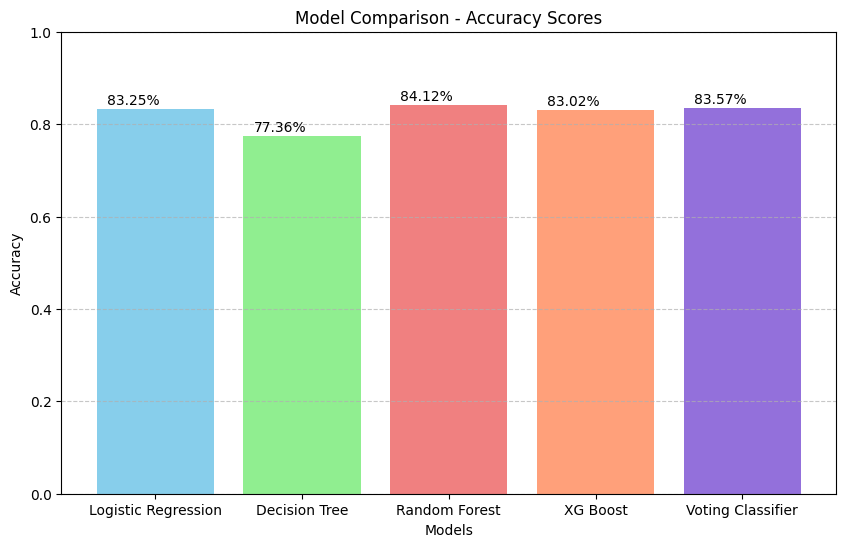

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these values with the actual accuracy scores of your models
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XG Boost', 'Voting Classifier']
accuracy_scores = [0.8325, 0.7736, 0.8412, 0.8302, 0.8357]

# Defining colors for each model
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'mediumpurple']

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracy_scores, color=colors)

# Adding data labels on top of the bars
for bar, score in zip(bars, accuracy_scores):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.01, f'{score:.2%}', ha='center', color='black', fontsize=10)

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison - Accuracy Scores')

# Adding gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set the y-axis limit to represent accuracy percentage (0 to 100%)
plt.ylim(0, 1)

# Display the plot
plt.show()
